In [92]:
import sqlite3
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import lsst.afw.image as afwImage
from lsst.daf.persistence import Butler
from astropy.table import Table
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()
import fakeInjectionPipeline as fip
import data_process_utils as dpu

In [24]:
patch_list = ['00']
host_mag_list = ['20_21']
fake_mag_list = [20]
injection_db_path = './data/table/gal_4639/injection_coord.sqlite'

In [48]:
calexp_info_dict, injection_coord_dict = fip.get_calexp_injection_dict(
    patch_list, host_mag_list, dbpath=injection_db_path
)
calexp_info_dict['00_20_21'].iloc[0]

visit       1013665
filter            i
detector         79
Name: 0, dtype: object

In [ ]:
coadd_repo = '/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy'
calexp_repo = '/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-calexp-v1'
coadd_butler = Butler(coadd_repo)
calexp_butler = Butler(calexp_repo)
coadd = coadd_butler.get('deepCoadd', {'tract': 4639, 'patch': '0,0', 'filter': 'i'})
calexp = calexp_butler.get('calexp', {'visit': 1013665, 'detector': 79, 'filter': 'i'})

In [56]:
calexp_info = {}
calexp_info['00_20_21'] = pd.DataFrame(data={'visit': [1013665], 'filter': ['i'], 'detector': [79]})
injection_coord ={}
injection_coord['00_20_21_1013665_79_i'] = injection_coord_dict['00_20_21_1013665_79_i']

In [57]:
coadd_psf = coadd.getPsf().computeShape()
calexp_psf = calexp.getPsf().computeShape()
np.sqrt(( coadd_psf.getIxx() + coadd_psf.getIyy()) / 2 ),np.sqrt(( calexp_psf.getIxx() + calexp_psf.getIyy()) / 2 )

(1.7323982449755941, 2.434330330020599)

In [58]:
fake_dir = f'./data/patch_0to6/injection'

injector = fip.fakeInjectionPipeline(
    fake_dir = fake_dir, patch_list = patch_list,
    host_mag_list=host_mag_list, fake_mag_list=fake_mag_list,
    calexp_info_dict=calexp_info, injection_coord_dict=injection_coord
)

In [61]:
config_list = ['al_spatial1', 'al_spatial2', 'al_spatial3', 'al_spatial4',
               'al_spatial1Pca', 'al_spatial2Pca', 'al_spatial3Pca', 'al_spatial4Pca']
"""
for cf_type in config_list:
    config = f'./config/diffimConfig_{cf_type}.py'
    file_path = f'./spatial_{cf_type}.sh'
    diff_dir =  f'./data/patch_0to6/diff/sptial_dof/{cf_type}'
    injector.get_subtraction_script(diff_dir , config=config,
                                    file_path=file_path, use_slurm=False)
""";

In [65]:
"""
for cf_type in config_list:
    diff_dir =  f'./data/patch_0to6/diff/sptial_dof/{cf_type}'
    flux_dir = f'./data/patch_0to6/diff/sptial_dof/{cf_type}/detection'
    injector.get_detection(diff_dir=diff_dir, flux_dir=flux_dir,
                           db_name=f'detection.sqlite')
""";

# Analysis

#### get data

In [80]:
diff_dict = {}
for config in config_list:
    diff_path = (f'./data/patch_0to6/diff/sptial_dof/{config}/00_20_21_1013665_79_i/diff_20/deepDiff/v01013665-fi'
                 '/R20/diffexp_01013665-i-R20-S21-det079.fits')
    diff_dict[config] = afwImage.ExposureF(diff_path)

In [72]:
base_flags = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad', 'base_NaiveCentroid_flag']

In [73]:
conn = sqlite3.connect('./data/patch_0to6/diff/sptial_dof/al_spatial1/detection/detection.sqlite')
art = pd.read_sql_query('SELECT * FROM artifact', conn)
art = Table.from_pandas(art)
base_rm = dpu.remove_flag_astropy(art, flag_list=base_flags)

In [128]:
artifact_stat = pd.DataFrame(index=['all artifacts', 'base flag applied'])
for config in config_list:
    artifact = pd.read_sql_query('SELECT * FROM artifact', conn)
    artifact = Table.from_pandas(artifact)
    base_rm = dpu.remove_flag_astropy(artifact, flag_list=base_flags)
    artifact_stat[config.split('_')[1]] = [len(artifact), len(base_rm)]

In [ ]:
# flux residual
flux_dict = {}
for config in config_list:
    conn = sqlite3.connect(f'./data/patch_0to6/diff/sptial_dof/{config}/detection/detection.sqlite')
    query = (f"SELECT * FROM fake_src")
    flux = pd.read_sql_query(query, conn)
    flux_dict[config] = flux

norm_x = np.arange(-5, 5, 0.1)
norm_y = stats.norm.pdf(norm_x)
res_list = []
for j, config in enumerate(config_list):
    flux = flux_dict[config]
    flux_det = flux.loc[flux.matched_status.astype(bool)]
    eff = eff = len(flux_det) / len(flux)
    res = (flux_det.base_PsfFlux_instFlux - flux_det.injected_instFlux) / flux_det.injected_instFlux
    res_list.append(list(res))

#### Algorithm (Alard-Lupton)

\begin{align}
M(x,y) &= [R \otimes K](x, y) + B(x,y),  \\
K(u,v,x,y) &= \Sigma_{q=1}^{N_k}a_q(x,y)k_q(u,v), \\
a_q(x,y) &= \Sigma_{m=0}^{d_q} \Sigma_{n=0}^{d_q-m}a_{qmn}(\frac{x-x_c}{N_x})^m(\frac{y-y_c}{N_y})^n, \\
B(x,y) &= \Sigma_{k=0}^{d_B} \Sigma_{l=0}^{d_B-k}b_{kl}(\frac{x-x_c}{N_x})^k(\frac{y-y_c}{N_y})^l.
\end{align}

In this notebook, we explore the effect of $d_q$ on artifact removal.

#### artifact statistics

In [129]:
artifact_stat

,spatial1,spatial2,spatial3,spatial4,spatial1Pca,spatial2Pca,spatial3Pca,spatial4Pca
all artifacts,15,15,15,15,15,15,15,15
base flag applied,3,3,3,3,3,3,3,3


#### postage stamps

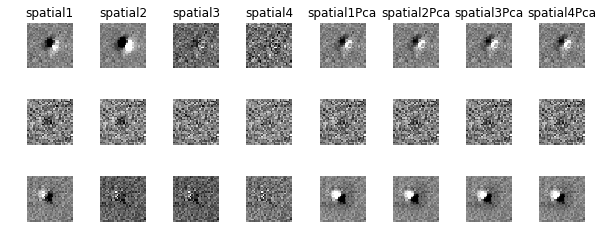

In [90]:
fig, ax = plt.subplots(len(base_rm), len(config_list), figsize=(10,4))
fig.subplots_adjust(wspace=0.6)
for i, diaSrc in enumerate(base_rm):
    for j, config in enumerate(config_list):
        diff_exp = diff_dict[config]
        x = diaSrc['base_NaiveCentroid_x']
        y = diaSrc['base_NaiveCentroid_y']
        diff_stamp = dpu.make_cutout(diff_exp, x, y, cutout_size=30)
        ax[i][j].imshow(interval(diff_stamp.getImage().array), cmap='gray', origin='lower')
        ax[i][j].axis('off')
        if i == 0:
            ax[i][j].set_title(config.split('_')[1])

#### flux residual

We inject simulated point sources at 20 magnitude.

(-0.05, 0.05)

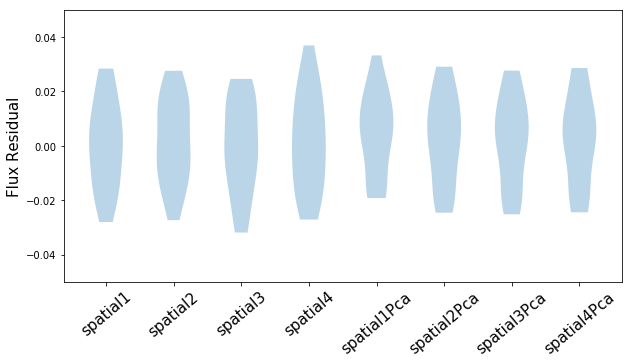

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.2)
ax.violinplot(res_list, showmedians=False, showextrema=False);
ax.set_xticks([1,2,3,4,5,6,7,8])
ax.set_xticklabels(['spatial1', 'spatial2', 'spatial3', 'spatial4',
                    'spatial1Pca', 'spatial2Pca', 'spatial3Pca', 'spatial4Pca'],  rotation=40, size=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_ylabel('Flux Residual', size=15)
ax.set_ylim((-0.05, 0.05))